Final Lab
=========

#### **Alumno**: Mario Ferreyra

## Main task

In this notebook, we will apply transfer learning techniques to finetune the [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) CNN on [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

## Procedures

In general, the main steps that we will follow are:

1. Load data, analyze and split in *training*/*validation*/*testing* sets.
2. Load CNN and analyze architecture.
3. Adapt this CNN to our problem.
4. Setup data augmentation techniques.
5. Add some keras callbacks.
6. Setup optimization algorithm with their hyperparameters.
7. Train model!
8. Choose best model/snapshot.
9. Evaluate final model on the *testing* set.

In [1]:
%matplotlib inline

# Setup one GPU for tensorflow (don't be greedy).
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0.5"  # The GPU id to use, "0", "1", etc.

# https://keras.io/applications/#documentation-for-individual-models
from keras.applications.mobilenet import MobileNet
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from keras.models import load_model
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Limit tensorflow GPU usage.
# Maybe you should comment this lines if you run tensorflow on CPU.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8

sess = tf.Session(config=config)

In [3]:
sns.set_style('whitegrid')
sns.set_context('talk')

## 1. Load data, analyze and split in *training* / *validation* / *testing* sets

El dataset CIFAR-10 consiste de 60000 imagenes a color.

Estas imagenes estan separadas en 10 clases diferentes:
* 0 : Airplane
* 1 : Automobile
* 2 : Bird
* 3 : Cat
* 4 : Deer
* 5 : Dog
* 6 : Frog
* 7 : Horse
* 8 : Ship
* 9 : Truck

Las imagenes tienen una dimension de **32** x **32**

In [4]:
CIFAR_IMG_ROWS = 32
CIFAR_IMG_COLS = 32

# Cifar-10 class names
# We will create a dictionary for each type of label
# This is a mapping from the int class name to their corresponding string class name
LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Load dataset from keras
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
############
# [COMPLETE] 
# Add some prints here to see the loaded data dimensions
############
print("CIFAR-10:")
print("\t* x_train shape = {}".format(x_train.shape))
print("\t* y_train shape = {}".format(y_train.shape))
print("")
print("\t* x_test  shape = {}".format(x_test.shape))
print("\t* y_test  shape = {}".format(y_test.shape))

CIFAR-10:
	* x_train shape = (50000, 32, 32, 3)
	* y_train shape = (50000, 1)

	* x_test  shape = (10000, 32, 32, 3)
	* y_test  shape = (10000, 1)


In [6]:
#y_train = np.array([y[0] for y in y_train])
y_train = y_train.reshape((50000,))

#y_test = np.array([y[0] for y in y_test])
y_test = y_test.reshape((10000,))

In [7]:
print("CIFAR-10:")
print("\t* x_train shape = {}".format(x_train.shape))
print("\t* y_train shape = {}".format(y_train.shape))
print("")
print("\t* x_test  shape = {}".format(x_test.shape))
print("\t* y_test  shape = {}".format(y_test.shape))

CIFAR-10:
	* x_train shape = (50000, 32, 32, 3)
	* y_train shape = (50000,)

	* x_test  shape = (10000, 32, 32, 3)
	* y_test  shape = (10000,)


Notamos que los conjuntos se distribuyen como sigue:
* **Train**: 50000 imagenes
* **Test**: 10000 imagenes

In [8]:
############
# [COMPLETE] 
# Analyze the amount of images for each class.
# Plot some images to explore how they look
############

def get_classes_distribution(y_data):
    # Get the count for each label
    y = np.bincount(y_data)
    ii = np.nonzero(y)[0]
    label_counts = zip(ii, y[ii])

    # Get total number of samples
    total_samples = len(y_data)

    # Count the number of items in each class
    for label, count in label_counts:
        class_name = LABELS[label]
        percent = (count / total_samples) * 100
        print("{:<15s}:  {} or {:.2f}%".format(class_name, count, percent))
        
    return label_counts


def plot_label_per_class(y_data, title=None):
    classes = sorted(np.unique(y_data))
    f, ax = plt.subplots(1, 1, figsize=(12, 4))
    g = sns.countplot(y_data, order=classes)
    g.set_title("Number of labels for each class: {}".format(title))
    
    for p, label in zip(g.patches, classes):
        g.annotate(LABELS[label], (p.get_x(), p.get_height() + 0.2))

    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

Conjunto de **Train**: Veamos cuantas imagenes hay por cada clases y como estan distribuidas.

airplane       :  5000 or 10.00%
automobile     :  5000 or 10.00%
bird           :  5000 or 10.00%
cat            :  5000 or 10.00%
deer           :  5000 or 10.00%
dog            :  5000 or 10.00%
frog           :  5000 or 10.00%
horse          :  5000 or 10.00%
ship           :  5000 or 10.00%
truck          :  5000 or 10.00%


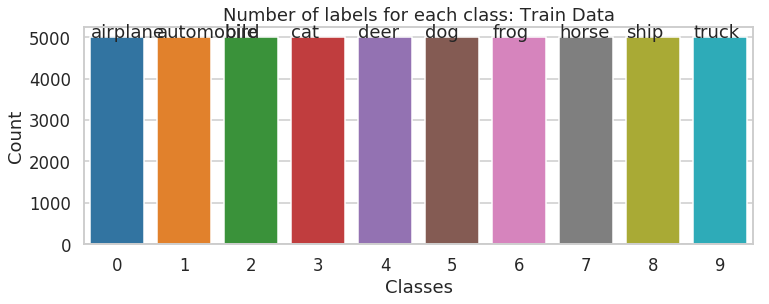

In [9]:
train_label_counts = get_classes_distribution(y_train)

plot_label_per_class(y_train, title='Train Data')

Conjunto de **Test**: Veamos cuantas imagenes hay por cada clases y como estan distribuidas.

airplane       :  1000 or 10.00%
automobile     :  1000 or 10.00%
bird           :  1000 or 10.00%
cat            :  1000 or 10.00%
deer           :  1000 or 10.00%
dog            :  1000 or 10.00%
frog           :  1000 or 10.00%
horse          :  1000 or 10.00%
ship           :  1000 or 10.00%
truck          :  1000 or 10.00%


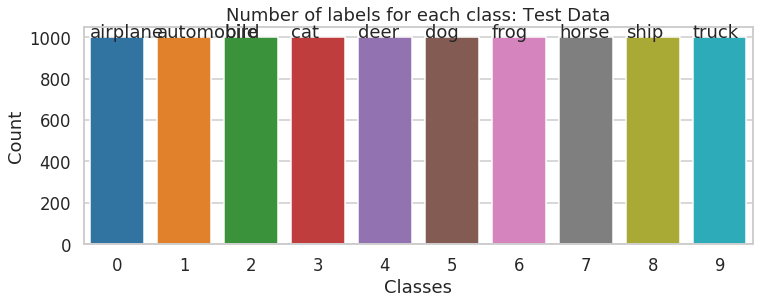

In [10]:
test_label_counts = get_classes_distribution(y_test)

plot_label_per_class(y_test, title='Test Data')

Notemos que tanto en el conjunto de **Train** y **Test**, la cantidad de imagenes por cada clase esta igualemente distribuida (10%)

In [11]:
def sample_images_data(x_data, y_data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in LABELS.keys():
        # Get four samples for each category
        samples = np.where(y_data == k)[0][:4]
        # Append the samples to the samples list
        for s in samples:
            img = x_data[s]
            sample_images.append(img)
            sample_labels.append(y_data[s])

    print("Total number of sample images to plot: ", len(sample_images))

    return sample_images, sample_labels


def plot_sample_images(data_sample_images, data_sample_labels, cmap="gray"):
    # Plot the sample images now
    f, ax = plt.subplots(5, 8, figsize=(16, 10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(LABELS[data_sample_labels[i]])
    plt.show()

Conjunto de **Train**: Tomemos una muestra de imagenes de cada clase y las grafiquemos

Total number of sample images to plot:  40


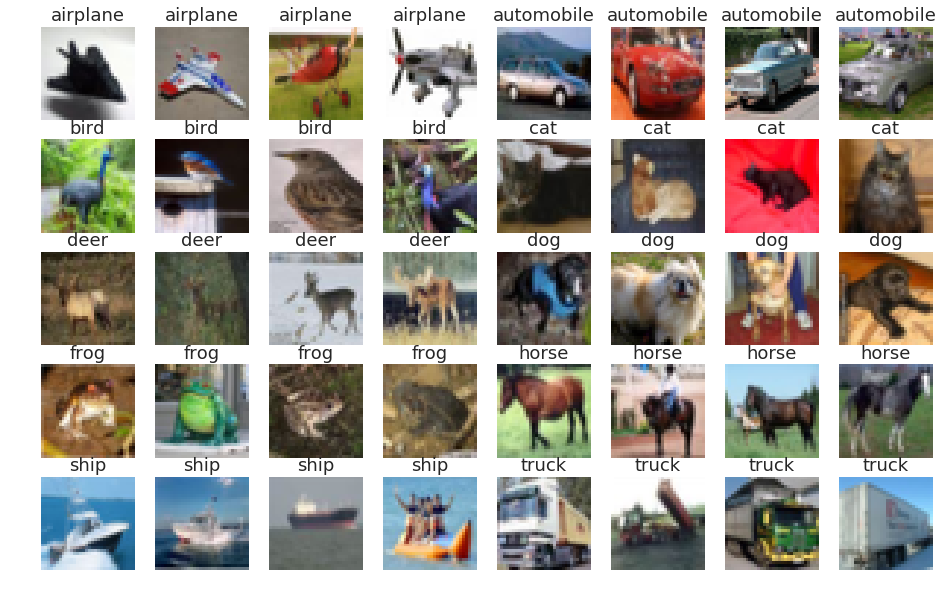

In [12]:
train_sample_images, train_sample_labels = sample_images_data(x_train, y_train)

plot_sample_images(train_sample_images, train_sample_labels)

Conjunto de **Test**: Tomemos una muestra de imagenes de cada clase y las grafiquemos

Total number of sample images to plot:  40


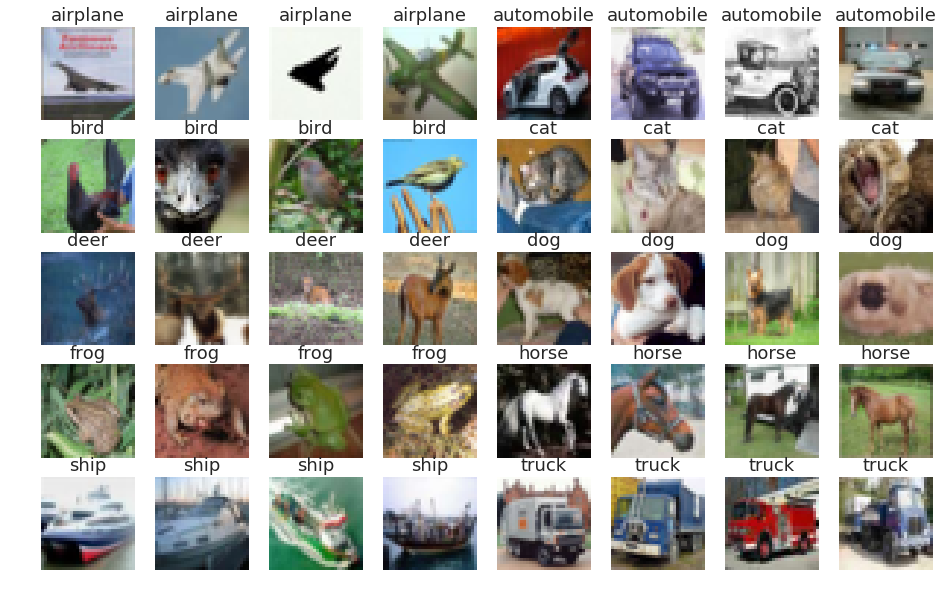

In [13]:
test_sample_images, test_sample_labels = sample_images_data(x_test, y_test)

plot_sample_images(test_sample_images, test_sample_labels)

Separemos el conjunto de **Train** en dos:
* **Train**: Nuevo conjunto de entrenamiento con el 80% de las imagenes del conjunto original
* **Validation**: Conjunto de validacion con el 20% de las imagenes del conjunto original

In [14]:
TEST_SIZE = 0.2
RANDOM_STATE = 1995

############
# [COMPLETE] 
# Split training set in train/val sets
# Use the sampling method that you want
############
X_train, X_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

X_test, y_test = x_test, y_test

print("CIFAR-10:")
print("\t* X_train shape = {}".format(X_train.shape))
print("\t* y_train shape = {}".format(y_train.shape))
print("")
print("\t* X_val   shape = {}".format(X_val.shape))
print("\t* y_val   shape = {}".format(y_val.shape))
print("")
print("\t* X_test  shape = {}".format(X_test.shape))
print("\t* y_test  shape = {}".format(y_test.shape))

CIFAR-10:
	* X_train shape = (40000, 32, 32, 3)
	* y_train shape = (40000,)

	* X_val   shape = (10000, 32, 32, 3)
	* y_val   shape = (10000,)

	* X_test  shape = (10000, 32, 32, 3)
	* y_test  shape = (10000,)


Esta es la distribucion de los nuevos conjuntos:
* **Train**: 50000 imagenes
* **Validation**: 10000 imagenes
* **Test**: 10000 imagenes


Veamos cuantas imagenes hay por cada clase sobre los conjuntos de **Train** y **Validation**

airplane       :  3957 or 9.89%
automobile     :  4046 or 10.12%
bird           :  4013 or 10.03%
cat            :  4062 or 10.15%
deer           :  3990 or 9.98%
dog            :  3960 or 9.90%
frog           :  3976 or 9.94%
horse          :  3984 or 9.96%
ship           :  4000 or 10.00%
truck          :  4012 or 10.03%


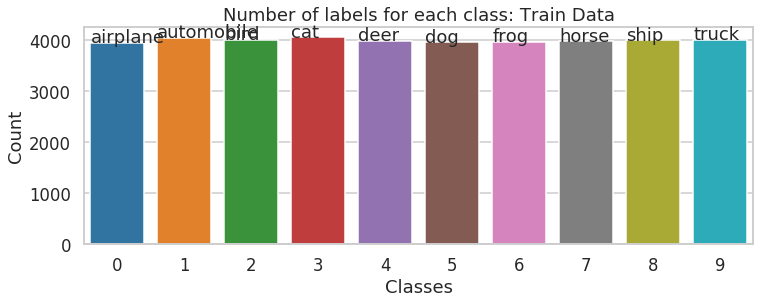

In [15]:
#get_classes_distribution(np.argmax(y_train, axis=1))
get_classes_distribution(y_train)

#plot_label_per_class(np.argmax(y_train, axis=1), title='Train')
plot_label_per_class(y_train, title='Train Data')

airplane       :  1043 or 10.43%
automobile     :  954 or 9.54%
bird           :  987 or 9.87%
cat            :  938 or 9.38%
deer           :  1010 or 10.10%
dog            :  1040 or 10.40%
frog           :  1024 or 10.24%
horse          :  1016 or 10.16%
ship           :  1000 or 10.00%
truck          :  988 or 9.88%


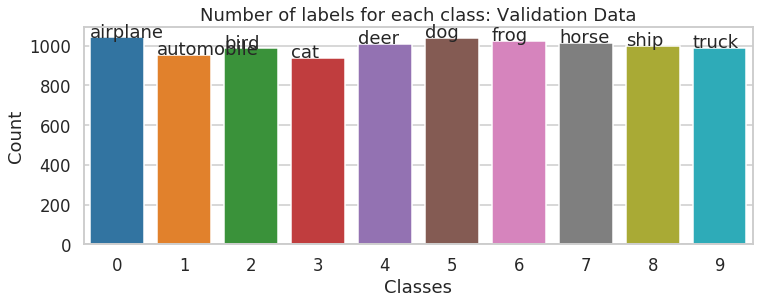

In [16]:
get_classes_distribution(y_val)

plot_label_per_class(y_val, title='Validation Data')

Apreciamos que los conjuntos se encuentran bien balanceado en cuanto a la cantidad de imagenes por cada clase.

In [17]:
# In order to use the MobileNet CNN pre-trained on imagenet, we have
# to resize our images to have one of the following static square shape: [(128, 128),
# (160, 160), (192, 192), or (224, 224)].
# If we try to resize all the dataset this will not fit on memory, so we have to save all
# the images to disk, and then when loading those images, our datagenerator will resize them
# to the desired shape on-the-fly.

# https://stackoverflow.com/questions/46844444/python-opencv-cannot-resize-image
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html#resize
def save_to_disk(x_data, y_data, usage, output_dir='cifar10_images'):
    """
    This function will resize your data using the specified output_size and 
    save them to output_dir.
    
    x_data : np.ndarray
        Array with images.
    
    y_data : np.ndarray
        Array with labels.
    
    usage : str
        One of ['train', 'val', 'test'].

    output_dir : str
        Path to save data.
    """
    assert usage in ['train', 'val', 'test']
    
    # Set paths 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for label in np.unique(y_data):
        label_path = os.path.join(output_dir, usage, str(label))
        if not os.path.exists(label_path):
            os.makedirs(label_path)
    
    for idx, img in enumerate(x_data):
        bgr_img = img[..., ::-1]  # RGB -> BGR
        #abel = y_data[idx][0]
        label = y_data[idx]
        img_path = os.path.join(output_dir, usage, str(label), 'img_{}.jpg'.format(idx))
        retval = cv2.imwrite(img_path, bgr_img)

        assert retval, 'Problem saving image at index: {}'.format(idx)

In [18]:
############
# [COMPLETE] 
# Use the above function to save all your data, e.g.:
#    save_to_disk(x_train, y_train, 'train', 'cifar10_images')
#    save_to_disk(x_val, y_val, 'val', 'cifar10_images')
#    save_to_disk(x_test, y_test, 'test', 'cifar10_images')
############

save_to_disk(X_train, y_train, 'train', output_dir='cifar10_images')
save_to_disk(X_val, y_val, 'val', output_dir='cifar10_images')
save_to_disk(X_test, y_test, 'test', output_dir='cifar10_images')

## 2. Load CNN and analyze architecture

In [19]:
# Some constants
NET_IMG_ROWS = 128
NET_IMG_COLS = 128
CHANNELS = 3
NUM_CLASSES = 10

In [20]:
############
# [COMPLETE] 
# Use the MobileNet class from Keras to load your base model, pre-trained on imagenet.
# We wan't to load the pre-trained weights, but without the classification layer.
# Check the notebook '3_transfer-learning' or https://keras.io/applications/#mobilenet to get more
# info about how to load this network properly.
############

base_model = MobileNet(
    input_shape=(NET_IMG_ROWS, NET_IMG_COLS, CHANNELS),  # Input image size
    include_top=False,                                   # Drop classification layer
    weights='imagenet',                                  # Use imagenet pre-trained weights
    pooling='avg'                                        # Global AVG pooling for the output vector
)

Inspeccionemos el modelo 'MobileNet' cargado

In [21]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

## 3. Adapt this CNN to our problem

In [22]:
def select_model(model_type, base_model, train_base_layers, drop_prob, num_classes):
    for layer in base_model.layers:
        layer.trainable = train_base_layers

    # Obtenemos el la salida del Feature Vector del "base model" cargado
    x = base_model.output

    if model_type == '1':
        x = Dense(1024, activation='relu')(x)  # Agregamos una capa Densa
        x = Dropout(drop_prob)(x)              # Agregamos capa de Dropout
        print("Model Type 1: 2 Layers")
    elif model_type == '2':
        x = Dense(128, activation='relu')(x)   # Agregamos una capa Densa
        x = Dropout(drop_prob)(x)              # Agregamos capa de Dropout
        x = Dense(256, activation='relu')(x)   # Agregamos una capa Densa
        x = Dropout(drop_prob)(x)              # Agregamos capa de Dropout
        x = Dense(512, activation='relu')(x)   # Agregamos una capa Densa
        x = Dropout(drop_prob)(x)              # Agregamos capa de Dropout
        x = Dense(1024, activation='relu')(x)  # Agregamos una capa Densa
        x = Dropout(drop_prob)(x)              # Agregamos capa de Dropout
        print("Model Type 2: 8 Layers")

    # Añadimos capa de clasificacion, usando 'Softmax'
    predictions = Dense(num_classes, activation='softmax')(x)

    # Creamos el modelo que sera entrenado
    model = Model(
        inputs=base_model.input,
        outputs=predictions
    )

    return model

In [23]:
def get_model_name(model_type, epochs, train_base_layers, drop_prob):
    exp_name = "model_{}_epochs_{}_train_base_layers_{}_drop_prob_{}"
    exp_name = exp_name.format(model_type, epochs, train_base_layers, drop_prob)

    return exp_name

In [24]:
############
# [COMPLETE] 
# Having the CNN loaded, now we have to add some layers to adapt this network to our classification problem.
# We can choose to finetune just the new added layers, some particular layers or all the layer of the model.
# Play with different settings and compare the results.
############
EPOCHS = 5
MODEL_TYPE = '1'
TRAIN_BASE_LAYERS = 0
DROP_PROB = 0.5

MODEL_NAME = get_model_name(MODEL_TYPE, EPOCHS, TRAIN_BASE_LAYERS, DROP_PROB)

model = select_model(MODEL_TYPE, base_model, bool(TRAIN_BASE_LAYERS), DROP_PROB, NUM_CLASSES)

Model Type 1: 2 Layers


#### Inspeccionemos el nuevo modelo creado

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

## 4. Setup data augmentation techniques

In [26]:
###########
# [COMPLETE] 
# Use data augmentation to train your model.
# Use the Keras ImageDataGenerator class for this porpouse.
# Note: Given that we want to load our images from disk, instead of using 
# ImageDataGenerator.flow method, we have to use ImageDataGenerator.flow_from_directory 
# method in the following way:
#     generator_train = dataget_train.flow_from_directory(
#         'resized_images/train', 
#         target_size=(128, 128),
#         batch_size=32
#     )
#     generator_val = dataget_train.flow_from_directory(
#         'resized_images/val', 
#         target_size=(128, 128),
#         batch_size=32
#     )
# Note that we have to resize our images to finetune the MobileNet CNN, this is done using 
# the target_size argument in flow_from_directory.
# Remember to set the target_size to one of the valid listed here:
#     [(128, 128), (160, 160), (192, 192), or (224, 224)].
############

# Training data generator
datagen_train = ImageDataGenerator(
    rescale=1./255,         # We also can make a rescale on the data
    horizontal_flip=True,
    rotation_range = 60,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Validation data generator
datagen_val = ImageDataGenerator(rescale=1./255)

# Test data generator
datagen_test = ImageDataGenerator(rescale=1./255)

In [27]:
# https://stackoverflow.com/questions/51305682/how-to-use-to-categorical-when-using-imagedatagenerator

generator_train = datagen_train.flow_from_directory(
    'cifar10_images/train', 
    target_size=(NET_IMG_ROWS, NET_IMG_COLS),
    class_mode='categorical',
    batch_size=32
)

generator_val = datagen_val.flow_from_directory(
    'cifar10_images/val', 
    target_size=(NET_IMG_ROWS, NET_IMG_COLS),
    class_mode='categorical',
    batch_size=32
)

generator_test = datagen_test.flow_from_directory(
    'cifar10_images/test', 
    target_size=(NET_IMG_ROWS, NET_IMG_COLS),
    class_mode='categorical',
    batch_size=32
)

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


## 5. Add some keras callbacks

In [29]:
############
# [COMPLETE] 
# Load and set some Keras callbacks here!
############

EXP_ID = 'experiments'
if not os.path.exists(EXP_ID):
    os.makedirs(EXP_ID)

PATH_WEIGHT = os.path.join(EXP_ID, 'weights')
if not os.path.exists(PATH_WEIGHT):
    os.makedirs(PATH_WEIGHT)

callbacks_list = [
    # ModelCheckpoin: Save the model after every epoch
    ModelCheckpoint(
        filepath=os.path.join(PATH_WEIGHT, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
        mode='auto'
    ),
    # TensorBoard: Basic visualizations.
    TensorBoard(
        log_dir=os.path.join(EXP_ID, 'logs'),
        write_graph=True,
        write_images=False
    ),
    # CSVLogger: Callback that streams epoch results to a csv file.
    CSVLogger(
        filename=os.path.join(EXP_ID, '{}.csv'.format(MODEL_NAME)),
        separator=',',
        append=True
    ),
]

## 6. Setup optimization algorithm with their hyperparameters

In [30]:
############
# [COMPLETE] 
# Choose some optimization algorithm and explore different hyperparameters.
# Compile your model.
############

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 7. Train model!

In [ ]:
############
# [COMPLETE] 
# Use fit_generator to train your model.
# e.g.:
#     model.fit_generator(
#         generator_train,
#         epochs=50,
#         validation_data=generator_val,
#         steps_per_epoch=generator_train.n // 32,
#         validation_steps=generator_val.n // 32
#     )
############

BATCH_SIZE = 32

train_model = model.fit_generator(
    generator_train,
    epochs=EPOCHS,
    validation_data=generator_val,
    steps_per_epoch=generator_train.n // BATCH_SIZE,
    validation_steps=generator_val.n // BATCH_SIZE,
    callbacks=callbacks_list,
)

## 8. Choose best model / snapshot

In [31]:
def plot_accuracy_and_loss(train_model, is_history=False):
    if not is_history:
        hist = train_model.history
    else:
        hist = train_model

    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))

    f, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].plot(epochs, loss, 'g', label='Training')
    ax[0].plot(epochs, val_loss, 'r', label='Validation')
    ax[0].set_title('Loss Curves')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, acc, 'g', label='Training')
    ax[1].plot(epochs, val_acc, 'r', label='Validation')
    ax[1].set_title('Accuracy Curves')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()


# def plot_loss_and_accuracy(model_history, acc_metric):
#     plt.figure(figsize=(18, 6))

#     # Loss Curves
#     plt.subplot(1, 2, 1)
#     plt.plot(model_history.history['loss'], color='#3c8fb9', linewidth=2, linestyle='dotted')
#     plt.plot(model_history.history['val_loss'], color='#f47a50', linewidth=3)
#     plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
#     plt.xlabel('Epochs', fontsize=16)
#     plt.ylabel('Loss', fontsize=16)
#     plt.title('Loss Curves', fontsize=16)

#     # Accuracy Curves
#     plt.subplot(1, 2, 2)
#     plt.plot(model_history.history[acc_metric], color='#3c8fb9', linewidth=2, linestyle='dotted')
#     plt.plot(model_history.history['val_' + acc_metric], color='#f47a50', linewidth=3)
#     plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
#     plt.xlabel('Epochs', fontsize=16)
#     plt.ylabel('Accuracy', fontsize=16)
#     plt.title('Accuracy (' + acc_metric + ') Curves', fontsize=16)

#     plt.show()

In [36]:
############
# [COMPLETE] 
# Analyze and compare your results.
# Choose the best model and snapshot, justify your election. 
############

EXPERIMENTS_DIR = './experiments/CSVs'
experiment_names = [name for name in os.listdir(EXPERIMENTS_DIR)]

df_list = []
for exp_name in experiment_names:
    _exp_name = exp_name.replace('.csv', '')
    _exp_name_list = _exp_name.split('_')
    
    df = pd.read_csv(os.path.join(EXPERIMENTS_DIR, exp_name))

    df['exp_name'] = exp_name
    df['model_type'] = _exp_name_list[1]
    df['epochs'] = _exp_name_list[3]
    df['train_base_layers'] = _exp_name_list[7]
    df['drop_prob'] = _exp_name_list[10]
    df = df[[
        'exp_name', 'model_type', 'epochs', 'train_base_layers', 'drop_prob',
        'epoch', 'acc', 'loss', 'val_acc', 'val_loss'
    ]]

    df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Shape: {}".format(df.shape))

Shape: (1600, 10)


In [37]:
df.sort_values(by=['val_acc', 'val_loss'], ascending=[False, True])

,exp_name,model_type,epochs,train_base_layers,drop_prob,epoch,acc,loss,val_acc,val_loss
990,model_1_epochs_100_train_base_layers_1_drop_pr...,1,100,1,0.5,90,0.969950,0.088897,0.9220,0.353177
583,model_2_epochs_100_train_base_layers_1_drop_pr...,2,100,1,0.0,83,0.973425,0.076002,0.9208,0.361097
570,model_2_epochs_100_train_base_layers_1_drop_pr...,2,100,1,0.0,70,0.969325,0.090009,0.9204,0.332535
185,model_1_epochs_100_train_base_layers_1_drop_pr...,1,100,1,0.25,85,0.971575,0.083849,0.9204,0.368887
590,model_2_epochs_100_train_base_layers_1_drop_pr...,2,100,1,0.0,90,0.976025,0.070665,0.9194,0.353698
993,model_1_epochs_100_train_base_layers_1_drop_pr...,1,100,1,0.5,93,0.971650,0.084830,0.9192,0.375339
287,model_1_epochs_100_train_base_layers_1_drop_pr...,1,100,1,0.0,87,0.974950,0.072353,0.9191,0.382223
1484,model_2_epochs_100_train_base_layers_1_drop_pr...,2,100,1,0.5,84,0.968725,0.092472,0.9191,0.384984
448,model_2_epochs_100_train_base_layers_1_drop_pr...,2,100,1,0.75,48,0.948775,0.151843,0.9186,0.315371
1447,model_2_epochs_100_train_base_layers_1_drop_pr...,2,100,1,0.5,47,0.949450,0.144618,0.9185,0.306959


Usamos dos arquitecturas de modelos, con las cuales realizamos 8 experimentos distintos sobre cada arquitectura con 100 epocas y diferentes parametros como son el entrenamiento de las capas base o el rate de las capas de Dropout.

Por lo que en total realizamos 16 experimentos. Luego de esto armamos un Dataframe con los datos de entrenamiento de cada experimento, seguido de esto ordenamos el Dataframe `val_acc` y `val_loss` para de tal forma quedarnos con los parametros que maximizan la `val_acc` y minimizan la `val_loss`.   

Como primera conclusion, vemos que entrenar las _capas base_ mejora significativamente la performance del modelo.

Nos vamos a quedar con los dos mejores modelos de cada arquitectura, ellos son:
* `model_1_epochs_100_train_base_layers_1_drop_prob_0.5`
* `model_2_epochs_100_train_base_layers_1_drop_prob_0.0`


Analizemos las curvas de estos modelos 

In [38]:
df_1 = pd.read_csv(os.path.join(EXPERIMENTS_DIR, 'model_1_epochs_100_train_base_layers_1_drop_prob_0.5.csv'))

df_2 = pd.read_csv(os.path.join(EXPERIMENTS_DIR, 'model_2_epochs_100_train_base_layers_1_drop_prob_0.0.csv'))

In [39]:
df_1.sort_values(by=['val_acc', 'val_loss'], ascending=[False, True]).head(10)

,epoch,acc,loss,val_acc,val_loss
90,90,0.969950,0.088897,0.9220,0.353177
93,93,0.971650,0.084830,0.9192,0.375339
70,70,0.963825,0.106309,0.9171,0.350611
72,72,0.964850,0.100952,0.9167,0.366096
57,57,0.958200,0.121062,0.9161,0.357934
69,69,0.963600,0.102355,0.9158,0.369454
78,78,0.968925,0.091260,0.9152,0.368258
77,77,0.967800,0.097738,0.9152,0.373079
92,92,0.971150,0.087551,0.9147,0.384208
75,75,0.966675,0.099062,0.9144,0.376327


In [40]:
df_2.sort_values(by=['val_acc', 'val_loss'], ascending=[False, True]).head(10)

,epoch,acc,loss,val_acc,val_loss
83,83,0.973425,0.076002,0.9208,0.361097
70,70,0.969325,0.090009,0.9204,0.332535
90,90,0.976025,0.070665,0.9194,0.353698
84,84,0.974025,0.076167,0.9170,0.355369
59,59,0.962850,0.103088,0.9169,0.334391
91,91,0.975675,0.071101,0.9166,0.346495
76,76,0.969225,0.088492,0.9162,0.351967
53,53,0.958350,0.120218,0.9158,0.305475
68,68,0.965825,0.097893,0.9147,0.324651
96,96,0.977150,0.068241,0.9141,0.383792


[]

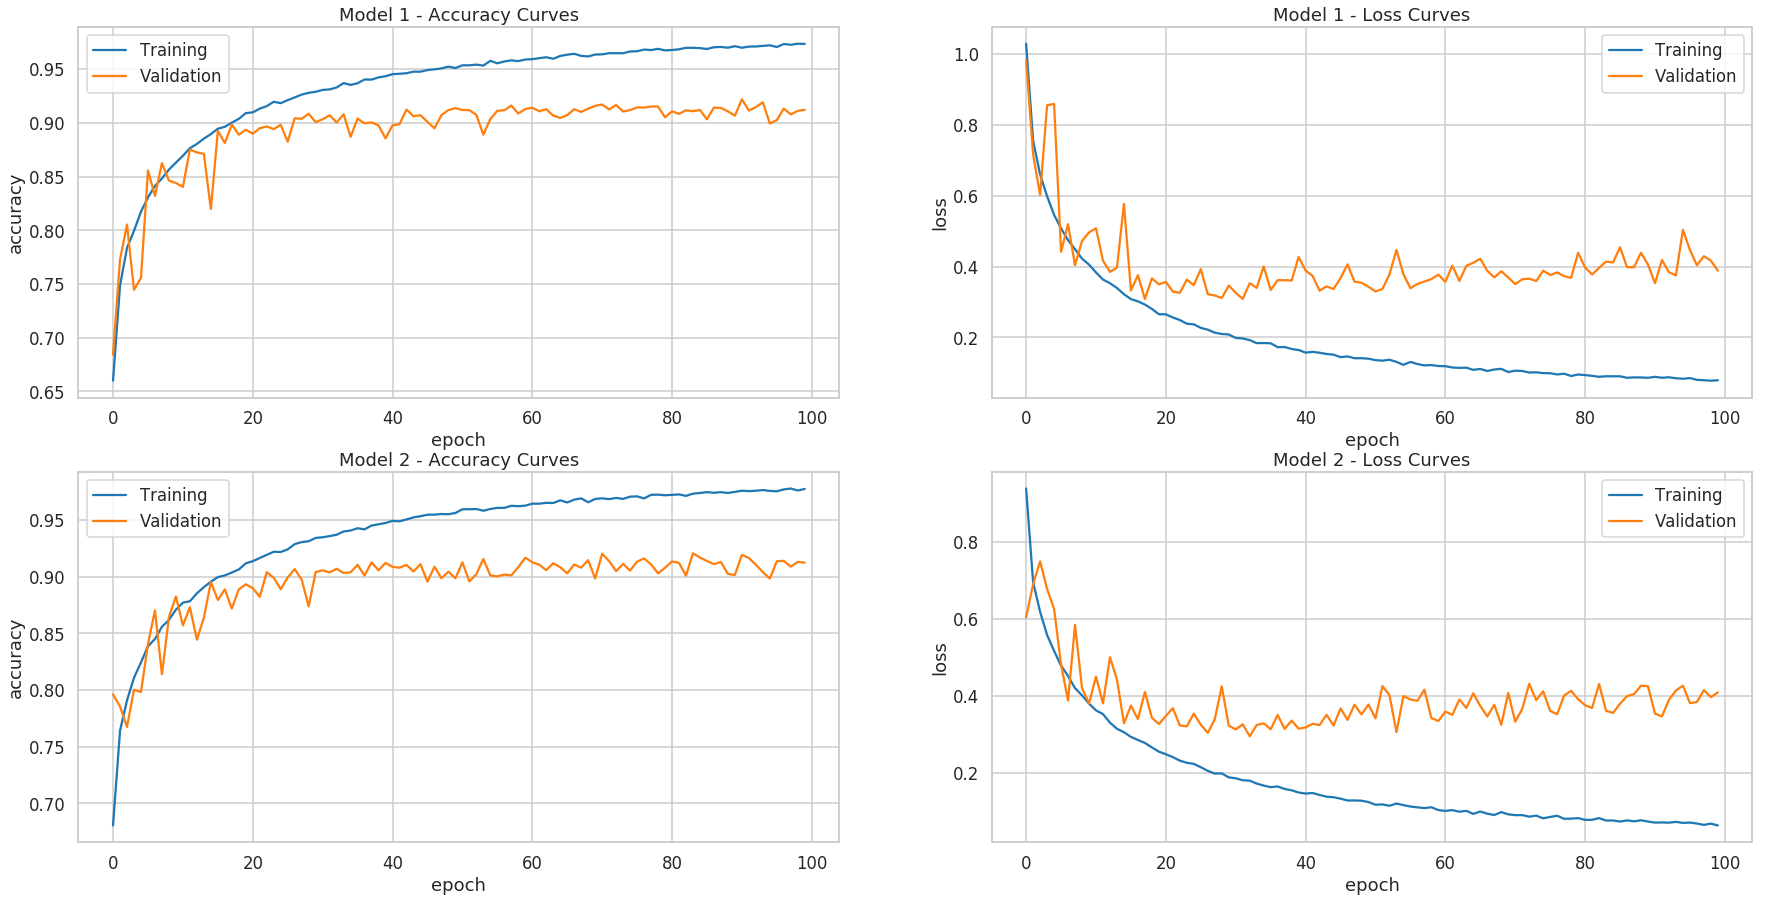

In [41]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 15))

acc_train_val = df_1[['epoch', 'acc', 'val_acc']].melt('epoch', var_name='metrics', value_name='accuracy')
ax_acc = sns.lineplot(x="epoch", y="accuracy", hue='metrics', data=acc_train_val, ax=ax[0][0])
ax_acc.legend(labels=['Training', 'Validation'])
ax_acc.set_title('Model 1 - Accuracy Curves')
ax_acc.plot()

loss_train_val = df_1[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='metrics', value_name='loss')
ax_l = sns.lineplot(x="epoch", y="loss", hue='metrics', data=loss_train_val, ax=ax[0][1])
ax_l.legend(labels=['Training', 'Validation'])
ax_l.set_title('Model 1 - Loss Curves')
ax_l.plot()

acc_train_val = df_2[['epoch', 'acc', 'val_acc']].melt('epoch', var_name='metrics', value_name='accuracy')
ax_acc = sns.lineplot(x="epoch", y="accuracy", hue='metrics', data=acc_train_val, ax=ax[1][0])
ax_acc.legend(labels=['Training', 'Validation'])
ax_acc.set_title('Model 2 - Accuracy Curves')
ax_acc.plot()

loss_train_val = df_2[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='metrics', value_name='loss')
ax_l = sns.lineplot(x="epoch", y="loss", hue='metrics', data=loss_train_val, ax=ax[1][1])
ax_l.legend(labels=['Training', 'Validation'])
ax_l.set_title('Model 2 - Loss Curves')
ax_l.plot()

## 9. Evaluate final model on the *testing* set

In [42]:
############
# [COMPLETE] 
# Evaluate your model on the testing set.
############

model_1 = load_model('./experiments/model_1_epochs_100_train_base_layers_1_drop_prob_0.5/model_1_epochs_100_train_base_layers_1_drop_prob_0.5.h5')
model_2 = load_model('./experiments/model_2_epochs_100_train_base_layers_1_drop_prob_0.0/model_2_epochs_100_train_base_layers_1_drop_prob_0.0.h5')

In [43]:
# El mejor modelo que usa la arquitectura 1 consigue una mejor accuracy en validacion en la epoca 90

# Loading best model snapshot weights
model_1.load_weights('./experiments/model_1_epochs_100_train_base_layers_1_drop_prob_0.5/weights/weights.90-0.45.hdf5')
model_1.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
# El mejor modelo que usa la arquitectura 2 consigue una mejor accuracy en validacion en la epoca 83

# Loading best model snapshot weights
model_2.load_weights('./experiments/model_2_epochs_100_train_base_layers_1_drop_prob_0.0/weights/weights.83-0.39.hdf5')
model_2.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
model_1_test_loss, model_1_test_acc = model_1.evaluate_generator(generator_test)
model_2_test_loss, model_2_test_acc = model_2.evaluate_generator(generator_test)

print("Modelo 1 - Evaluacion en Test:")
print("\t* Accuracy = {}".format(model_1_test_acc))
print("\t* Loss     = {}".format(model_1_test_loss))
print("\n")
print("Modelo 2 - Evaluacion en Test:")
print("\t* Accuracy = {}".format(model_2_test_acc))
print("\t* Loss     = {}".format(model_2_test_loss))

Modelo 1 - Evaluacion en Test:
	* Accuracy = 0.9048
	* Loss     = 0.44184454962313174


Modelo 2 - Evaluacion en Test:
	* Accuracy = 0.9044
	* Loss     = 0.43207158825695513
